# Sequential Monte Carlo - Approximate Bayesian Computation

Approximate Bayesian Computation methods (also called likelihood free inference methods), are a group of techniques developed for inferring posterior distributions in cases where the likelihood function is intractable or costly to evaluate. This does not mean that the likelihood function is not part of the analysis, rather that it is not directly evaluated. 

ABC comes useful when modelling complex phenomena in certain fields of study, like systems biology. Such models often contain unobservable random quantities, which make the likelihood function hard to specify, but data can be simulated from the model.  

These methods follow a general form:

1- Sample a parameter $\theta^*$ from a prior/proposal distribution $\pi(\theta)$.

2- Simulate a data set $y^*$ using a function that takes $\theta$ and returns a data set of the same dimensions as the observed data set $y_0$ (simulator).

3- Compare the simulated dataset $y^*$ with the experimental data set $y_0$ using a distance function $d$ and a tolerance threshold $\epsilon$. 


In some cases a distance function is computed between two summary statistics $d(S(y_0), S(y^*))$, avoiding the issue of computing distances for entire datasets.

As a result we obtain a sample of parameters from a distribution $\pi(\theta | d(y_0, y^*)) \leqslant \epsilon$. 

If $\epsilon$ is sufficiently small this distribution will be a good approximation of the posterior distribution $\pi(\theta | y_0)$.

[Sequential monte carlo](https://docs.pymc.io/notebooks/SMC2_gaussians.html?highlight=smc) ABC is a method that iteratevly morphs the prior into a posterior by propagating the sampled parameters through a series of proposal distributions $\phi(\theta^{(i)})$, weighting the accepted parameters $\theta^{(i)}$ like:

$$ w^{(i)} \propto \frac{\pi(\theta^{(i)})}{\phi(\theta^{(i)})} $$

It combines the advantages of traditional SMC, i.e. ability to sample from distributions with multiple peaks, but without the need for evaluating the likelihood function. 

_(Lintusaari, 2016), (Toni, T., 2008), (Nuñez, Prangle, 2015)_

In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

# A trivial example
Estimating the mean and standard deviation of normal data

In [2]:
data = np.random.normal(loc=0, scale=1, size=1000)

In [3]:
def normal_sim(a, b):
    return np.sort(np.random.normal(a, b, 1000))

In [4]:
with pm.Model() as example:
    a = pm.Normal('a', mu=0, sd=5)
    b = pm.HalfNormal('b', sd=1)
    s = pm.Simulator('s', normal_sim, observed=np.sort(data))
    trace_example = pm.sample(step=pm.SMC(ABC=True, epsilon=0.1))

Sample initial stage: ...
/home/agustina/Documents/pymc3/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.002 Steps: 25
Stage: 1 Beta: 0.023 Steps: 7
Stage: 2 Beta: 0.102 Steps: 3
Stage: 3 Beta: 0.334 Steps: 6
Stage: 4 Beta: 0.995 Steps: 4
Stage: 5 Beta: 1.000 Steps: 5


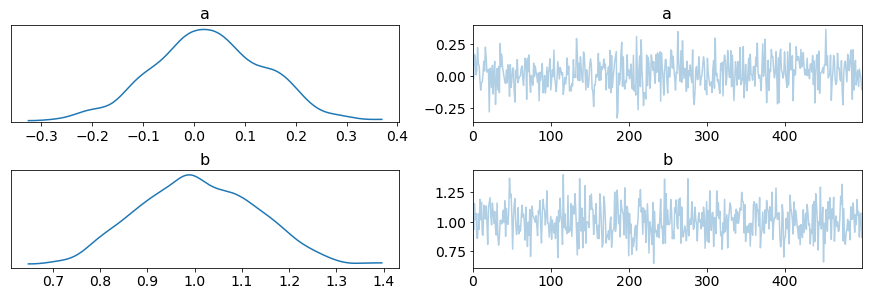

In [5]:
az.plot_trace(trace_example);

In [6]:
az.summary(trace_example)

,mean,sd,mc error,hpd 3%,hpd 97%
a,0.03,0.11,0.01,-0.21,0.21
b,1.01,0.13,0.01,0.77,1.24


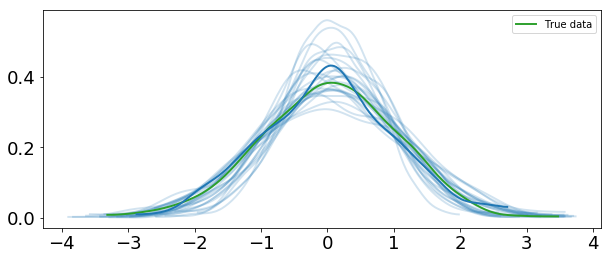

In [7]:
_, ax = plt.subplots(figsize=(10,4))
az.plot_kde(data, label='True data', ax=ax, plot_kwargs={'color':'C2'})
az.plot_kde(normal_sim(trace_example['a'].mean(), trace_example['b'].mean()), ax=ax)
for i in np.random.randint(0, 500, 25):
    az.plot_kde(normal_sim(trace_example['a'][i], trace_example['b'][i]), ax=ax, plot_kwargs={'zorder':0, 'alpha':0.2})
ax.legend();

# Lotka–Volterra
In this example we will try to find parameters for the Lotka-Volterra equations. A common biological competition model for describing how the number of individuals of each species changes when there is a predator/prey interaction (A Biologist’s Guide to Mathematical Modeling in Ecology and Evolution,Otto and Day, 2007). For example, rabbits and foxes. Given an initial population number for each species, the integration of this ordinary differential equations (ODE) describes curves for the progression of both populations. This ODE’s takes four parameters:

*    a is the natural growing rate of rabbits, when there’s no fox.
*    b is the natural dying rate of rabbits, due to predation.
*    c is the natural dying rate of fox, when there’s no rabbit.
*    d is the factor describing how many caught rabbits let create a new fox.

This example is based on the Scipy Lokta-Volterra Tutorial.

In [8]:
from scipy.integrate import odeint

First we will generate data using known parameters.

In [9]:
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10., 5.]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([a*X[0] - b*X[0]*X[1], 
                  -c*X[1] + d*b*X[0]*X[1]])

This model is based on a simulator, a function that returns data in the same dimensions as the observed data. In this case, the function solves the ODE. 

In [10]:
# simulator function
def competition_model(a, b): 
    return odeint(dX_dt, y0=X0, t=t, rtol=0.1, args=(a, b, c, d))

Using the simulator function we will obtain a dataset with some noise added, for using it as observed data.

In [11]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(a, b)
    simulated += noise
    indexes = np.sort(np.random.randint(low=0, high=size, size=size))    
    return simulated[indexes]

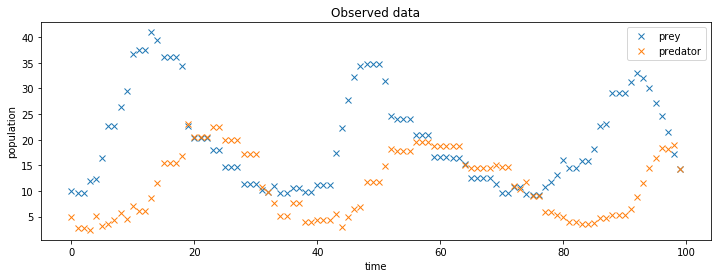

In [12]:
# plotting observed data.
observed = add_noise(a, b, c, d )
_, ax = plt.subplots(figsize=(12,4))
ax.plot(observed[:,0], 'x', label='prey')
ax.plot(observed[:,1], 'x', label='predator')
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.set_title('Observed data')
ax.legend();

On this model, instead of specifyng a likelihood function, we use `pm.Simulator()`, a "container" that stores the simulator function and the observed data. During sampling, samples from a and b priors will be passed to the simulator function.

In [14]:
with pm.Model() as model:
    
    a = pm.Normal('a', mu=1, sd=5)
    b = pm.Normal('b', mu=1, sd=5)

    simulator = pm.Simulator('simulator', competition_model, observed=observed)
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=1), draws=1000)

Sample initial stage: ...
/home/agustina/Documents/pymc3/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
/home/agustina/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/agustina/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Stage: 0 Beta: 0.024 Steps: 25
Stage: 1 Beta: 0.049 Steps: 9
Stage: 2 Beta: 0.074 Steps: 7
Stage: 3 Beta: 0.115 Steps: 17
Stage: 4 Beta: 0.234 Steps: 20
Stage: 5 Beta: 0.642 Steps: 6
Stage: 6 Beta: 1.000 Steps: 5


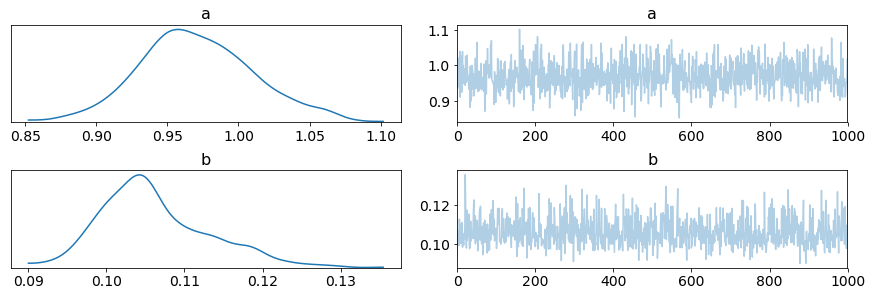

In [15]:
az.plot_trace(trace);

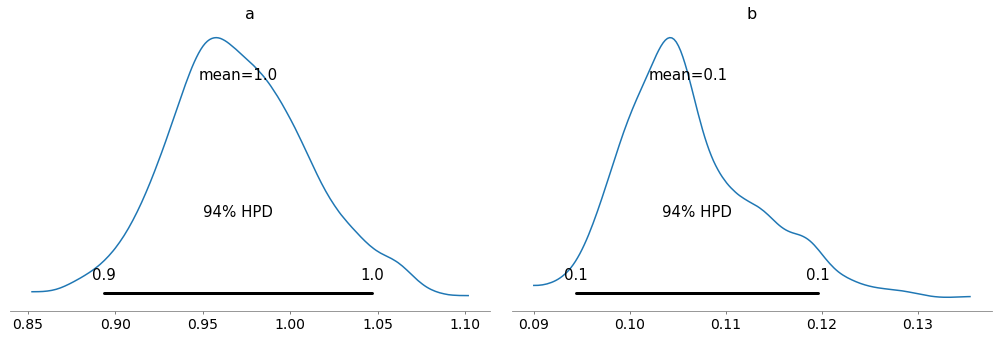

In [16]:
az.plot_posterior(trace);

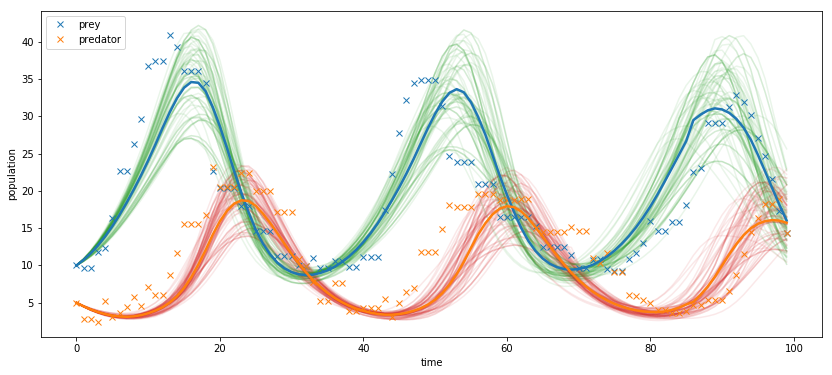

In [17]:
# plot results
_, ax = plt.subplots(figsize=(14,6))
ax.plot(observed[:,0], 'x', label='prey', c='C0')
ax.plot(observed[:,1], 'x', label='predator', c='C1')
ax.plot(competition_model(trace['a'].mean(), trace['b'].mean()), linewidth=2.5)
for i in np.random.randint(0, size, 75):
    ax.plot(competition_model(trace['a'][i], trace['b'][i])[:,0], alpha=0.1, c='C2', zorder=0)
    ax.plot(competition_model(trace['a'][i], trace['b'][i])[:,1], alpha=0.1, c='C3', zorder=0)
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend();